# Тестовое
<blockquote>
Дан датасет с данными о покупках пользователей.Структура полей:<br>
'order_time', 'order_id', 'product_id', 'sku_qty', 'category_id', 'category', 'brand_id', 'price', 'user_id', 'gender', 'c1', 'c2', 'c3'

### Необходимо:
#### python
1) преобразовать данные там, где это необходимо
2) построить когортный retantion rate (когорта - yyyymm)
3) посчитать когортный repurchase в 1 - 10 покупку
4) построить график среднего чека по категориям товаров
<br>
#### SQL 
Повторить пункты 2-3 на SQL
    </blockquote>

# `Python`
## 1. Преобразовать данные

In [90]:
%%time
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta


# Откроем
df = pd.read_csv('./jewelry.csv')
input_df_raw = df.copy(deep=True)

# Удалим пробелы в названиях столбцов
df.columns = list([i.strip() for i in df.columns.copy()])
df

# Конвертация времени
df['order_time'] = pd.to_datetime(df['order_time'], format='%Y-%m-%d %H:%M:%S UTC')
df = df.rename(columns={'order_time': 'order_ts'})

# Первый день месяца
df['order_month'] = df['order_ts'].to_numpy().astype('datetime64[M]')

# Удобный порядок столбцов
cols = ['user_id', 'gender', 'order_id', 'order_month', 'order_ts', 'category_id',
       'category', 'brand_id', 'product_id', 'c1', 'c2', 'c3', 'price', 'sku_qty']
df = df[cols].rename(columns={'gender': 'user_gender'})

# Во всех строках с условием user_id = nan, также нет товаров и их кол-ва. Дропнем эти строки
df = df.loc[df['user_id'].notna()].reset_index(drop=True).copy(deep=True)
df

# Теперь можем сконвертировать столбцы
df['user_id'] = df['user_id'].astype('int')
df['user_gender'] = df['user_gender'].astype('str')
df['user_gender'] = df['user_gender'].apply(lambda x: 'Неизвестно' if x == 'nan' else ('Женский' if x == 'f' else ('Мужской' if x == 'm' else x)))
df['category_id'] = df['category_id'].astype('int')
df['category'] = df['category'].fillna('Неизвестно').astype('str')
df['brand_id'] = df['brand_id'].fillna(-1).astype('int')
df[['c1', 'c2', 'c3']] = df[['c1', 'c2', 'c3']].fillna('?').astype('str')

# Проверка на дубликаты
lng1 = len(df)
df = df.drop_duplicates(keep='first')
lng2 = len(df)
print(f'Убрано {lng1 - lng2} полных строк-дубликатов')

# 
input_df = df.copy(deep=True)
input_df

Убрано 2469 полных строк-дубликатов
CPU times: user 304 ms, sys: 20.3 ms, total: 324 ms
Wall time: 323 ms


,user_id,user_gender,order_id,order_month,order_ts,category_id,category,brand_id,product_id,c1,c2,c3,price,sku_qty
0,1515915625207851264,Неизвестно,1924719191579951782,2018-12-01,2018-12-01 11:40:29,1806829201890738432,jewelry.earring,0,1842195256808833386,red,gold,diamond,561.51,1
1,1515915625071970048,Неизвестно,1924899396621697920,2018-12-01,2018-12-01 17:38:31,1806829201848795392,Неизвестно,-1,1806829193678291446,yellow,gold,?,212.14,1
2,1515915625048493568,Женский,1925511016616034733,2018-12-01,2018-12-02 13:53:42,1806829201915904256,jewelry.pendant,1,1842214461889315556,white,gold,sapphire,54.66,1
3,1515915625207630848,Женский,1925626951238681511,2018-12-01,2018-12-02 17:44:02,1806829201915904256,jewelry.pendant,0,1835566849434059453,red,gold,diamond,88.90,1
4,1515915625175329280,Неизвестно,1925740842841014667,2018-12-01,2018-12-02 21:30:19,1806829201924292864,jewelry.necklace,0,1873936840742928865,red,gold,amethyst,417.67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90554,1515915625720362496,Неизвестно,2719014477910507865,2021-12-01,2021-12-01 09:43:25,1806829201848795392,Неизвестно,0,1956663836392031039,red,gold,?,134.29,1
90555,1515915625720367360,Неизвестно,2719018098886705639,2021-12-01,2021-12-01 09:50:37,1806829201848795392,Неизвестно,0,1956663830729720074,red,gold,?,229.99,1
90556,1515915625720352000,Женский,2719018846999544322,2021-12-01,2021-12-01 09:52:06,1806829201890738432,jewelry.earring,1,1956663848219968336,white,gold,diamond,630.00,1
90557,1515915625720369664,Неизвестно,2719020596963836492,2021-12-01,2021-12-01 09:55:35,1806829201890738432,jewelry.earring,0,1835566854106513435,white,gold,fianit,83.42,1


## 2. Построить когортный retention rate (когорта - yyyymm)

In [116]:
%%time
'''Когортный анализ Retention по первой дате заказа клиентов'''
df = input_df.copy(deep=True)
df

# Первый заказ клиента
df['user_first_order_month'] = df.groupby(by=['user_id'], as_index=False)['order_ts'].transform('min').to_numpy().astype('datetime64[M]')

# На сколько месяцев отстаёт заказ от первого заказа клиента?
df['month_rn'] = df[['order_month', 'user_first_order_month']].apply(lambda x: relativedelta.relativedelta(x[0], x[1]).months + (12*relativedelta.relativedelta(x[0], x[1]).years), axis=1)

# Порядок столбцов
cols = ['user_id', 'user_gender', 'user_first_order_month',
        'order_id', 'month_rn', 'order_month', 'order_ts',
        'category_id', 'category', 'brand_id', 'product_id', 'c1', 'c2', 'c3',
        'price', 'sku_qty']
df = df[cols]
df

# Группировка
df_grp = df.groupby(by=['user_first_order_month', 'month_rn'], as_index=False)['user_id'].nunique()
df_grp = df_grp.rename(columns={'user_id': 'users_cnt'})

# Добавим столбцы
df_grp = df_grp.sort_values(by=['user_first_order_month', 'month_rn']).reset_index(drop=True)
df_grp['0_month_users_cnt'] = df_grp.groupby(by=['user_first_order_month'])['users_cnt'].transform('first')
df_grp['RetentionRate'] = df_grp['users_cnt'] / df_grp['0_month_users_cnt']
# df_grp.loc[df_grp['month_rn'] == 0, 'RetentionRate'] = df_grp.loc[df_grp['month_rn'] == 0, 'users_cnt']
df_grp = df_grp.rename(columns={'0_month_users_cnt': 'cohort_users_cnt'})
df_grp['RetentionRate'] = df_grp['RetentionRate'].apply(lambda x: round(x*100, 2))
df_grp

# Pivot
df_piv = pd.pivot_table(df_grp, index=['user_first_order_month', 'cohort_users_cnt'], columns=['month_rn'], values=['RetentionRate'])
df_piv

# Визуализация
# import seaborn as sns
# import matplotlib.pyplot as plt


# plt.figure(figsize=(18, 12))
# plt.title('Retention rates')
# sns.heatmap(data=df_piv, annot=True, fmt='.0%', vmin=0.0, vmax=1, cmap='BuGn')
# plt.show()

CPU times: user 3.81 s, sys: 0 ns, total: 3.81 s
Wall time: 3.81 s


RetentionRate                        
month_rn                                           0      1      2      3    
user_first_order_month cohort_users_cnt                                      
2018-12-01             66                       100.0  28.79  36.36  25.76  \
2019-01-01             188                      100.0  23.94  18.62  17.55   
2019-02-01             212                      100.0  12.26   9.91   8.96   
2019-03-01             206                      100.0   8.74   9.22   5.34   
2019-04-01             153                      100.0   9.80   9.15   9.80   
2019-05-01             152                      100.0   9.21   7.24   3.95   
2019-06-01             138                      100.0  12.32   7.97   3.62   
2019-07-01             215                      100.0   8.84   5.58  10.23   
2019-08-01             203                      100.0  10.34   8.37  15.27   
2019-09-01             150                      100.0  18.67  14.67  14.00   
2019-10-01             281                      100.0  19.57  12.46   9.61   
2019-11-01             330                      100.0  13.64   9.09   8.18   
2019-12-01             440                      100.0  13.18   9.32   5.45   
2020-01-01             337                      100.0  14.84   8.61   2.67   
2020-02-01             318                      100.0  11.95   1.89   1.57   
2020-03-01             359                      100.0   4.46   3.62   5.29   
2020-04-01             269                      100.0   4.46   1.12   2.23   
2020-05-01             231                      100.0   4.76   4.33   4.33   
2020-06-01             259                      100.0   9.27   8.11   8.11   
2020-07-01             309                      100.0   9.71   5.83   7.12   
2020-08-01             459                      100.0   8.28   6.10   4.58   
2020-09-01             508                      100.0   8.66   4.92   8.66   
2020-10-01             523                      100.0   9.37   6.50   3.25   
2020-11-01             717                      100.0  13.53   5.16   3.63   
2020-12-01             3569                     100.0   2.94   1.74   1.51   
2021-01-01             1667                     100.0   2.82   1.68   1.20   
2021-02-01             1717                     100.0   4.02   1.69   1.34   
2021-03-01             2135                     100.0   3.04   1.73   1.59   
2021-04-01             1453                     100.0   5.02   2.62   3.30   
2021-05-01             1425                     100.0   4.21   2.60   2.81   
2021-06-01             1399                     100.0   4.86   2.43   2.36   
2021-07-01             1618                     100.0   5.07   3.34   1.92   
2021-08-01             2214                     100.0   5.37   3.21   3.39   
2021-09-01             1564                     100.0   3.58   2.43    NaN   
2021-10-01             1490                     100.0   6.98   0.27    NaN   
2021-11-01             3737                     100.0   0.29    NaN    NaN   
2021-12-01             68                       100.0    NaN    NaN    NaN   

                                                                             
month_rn                                    4      5      6      7      8    
user_first_order_month cohort_users_cnt                                      
2018-12-01             66                24.24  22.73  28.79  27.27  27.27  \
2019-01-01             188               14.36  12.23  13.83  13.83  11.70   
2019-02-01             212                5.66  10.85   9.43   7.55  10.85   
2019-03-01             206                4.37   6.80   4.85   9.22  10.19   
2019-04-01             153                7.19   5.23  15.69   9.80  14.38   
2019-05-01             152                5.26  13.82  12.50  11.84   9.21   
2019-06-01             138               13.77  11.59  13.04   8.70   8.70   
2019-07-01             215                9.77   8.37  11.63   6.05   4.19   
2019-08-01             203               10.34  10.84   9.85 

Можно заметить, что у клиентов ранних когорт Retention выше. Чем позже клиенты делали свой первый заказ, тем менее вероятнее возвращались в следующие месяца. Здесь может быть несколько эффектов: **эффект низкой базы** (в 1ой когорте всего 66 человек), **плохой поток клиентов** (привлекаемые клиенты - не наша ЦА) или **деградирующий по Retention продукт**.

## 3. Посчитать когортный repurchase в 1 - 10 покупку

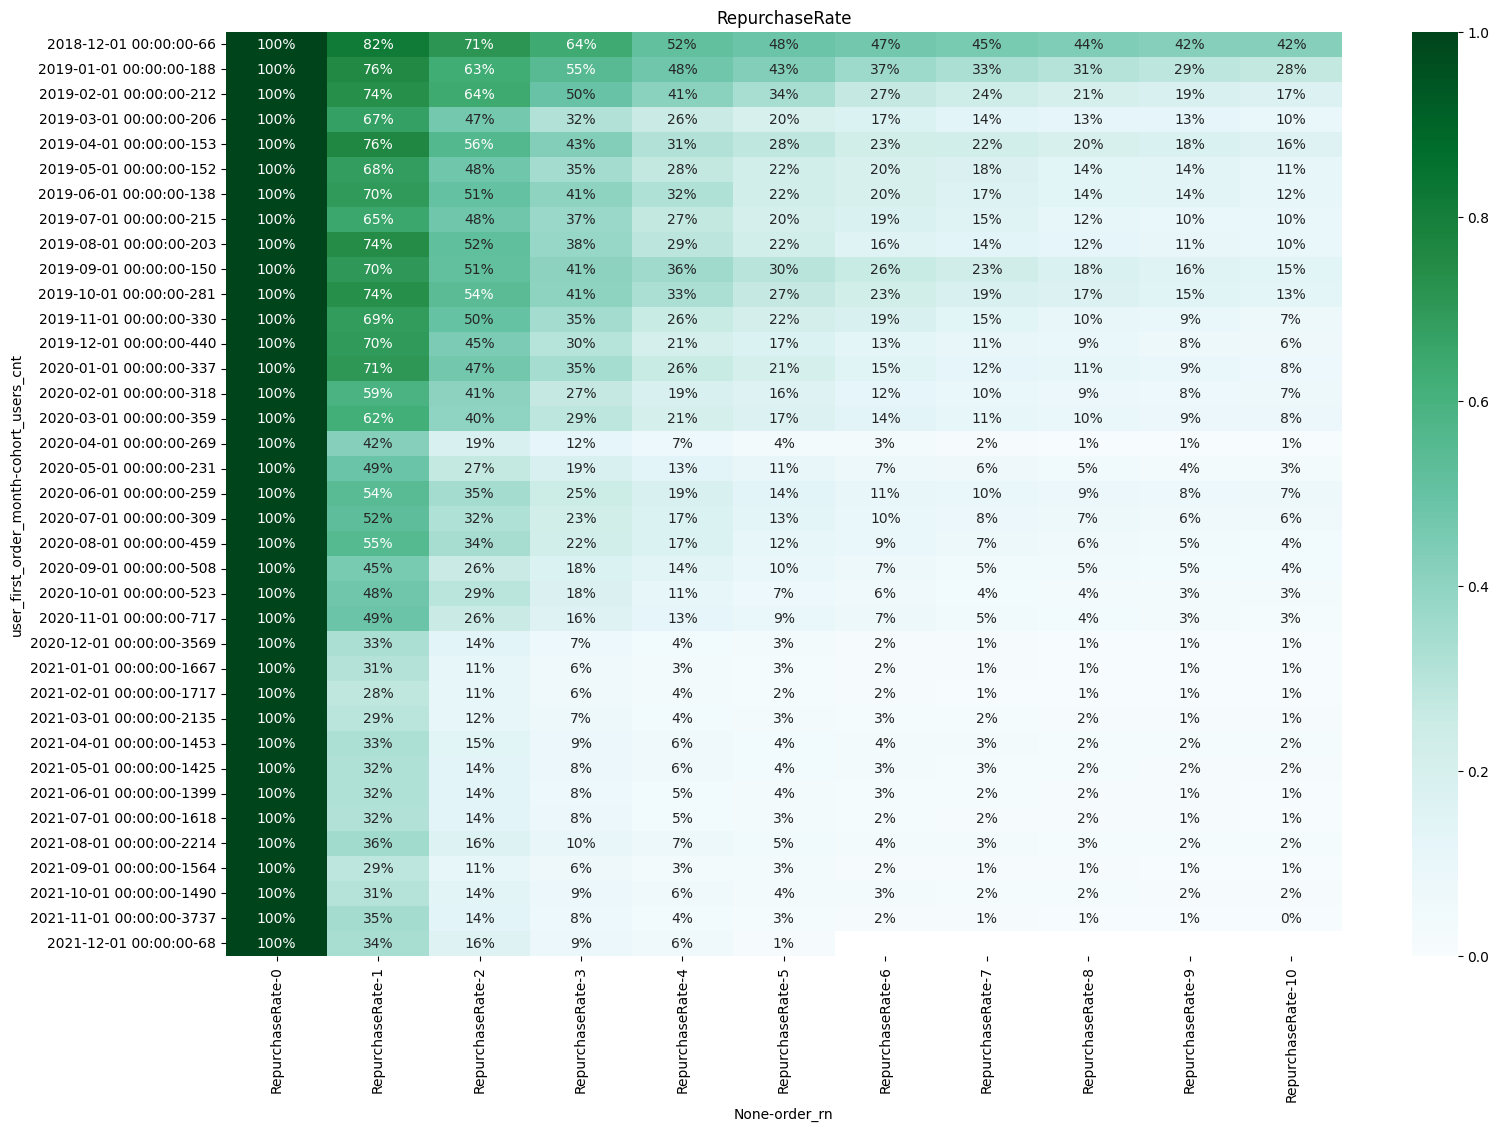

CPU times: user 567 ms, sys: 211 ms, total: 778 ms
Wall time: 562 ms


In [124]:
%%time
'''Когортный Repurchase по первой дате заказа клиентов'''
df = input_df.copy(deep=True)
df

# Первый заказ клиента
df['user_first_order_month'] = df.groupby(by=['user_id'], as_index=False)['order_ts'].transform('min').to_numpy().astype('datetime64[M]')

# Порядковый номер заказа у клиента
df['order_rn'] = df.groupby(by=['user_id'], as_index=False).cumcount()

# Оставим только первые 10 покупок
df = df.loc[df['order_rn'] <= 10].reset_index(drop=True).copy(deep=True)

# Порядок столбцов
cols = ['user_id', 'user_gender', 'user_first_order_month',
        'order_id', 'order_rn', 'order_month', 'order_ts',
        'category_id', 'category', 'brand_id', 'product_id', 'c1', 'c2', 'c3',
        'price', 'sku_qty']
df = df[cols]
df

# Группировка
df_grp = df.groupby(by=['user_first_order_month', 'order_rn'], as_index=False)['user_id'].nunique()
df_grp = df_grp.rename(columns={'user_id': 'users_cnt'})

# Добавим столбцы
df_grp = df_grp.sort_values(by=['user_first_order_month', 'order_rn']).reset_index(drop=True)
df_grp['0_month_users_cnt'] = df_grp.groupby(by=['user_first_order_month'])['users_cnt'].transform('first')
df_grp['RepurchaseRate'] = df_grp['users_cnt'] / df_grp['0_month_users_cnt']
# df_grp.loc[df_grp['month_rn'] == 0, 'RetentionRate'] = df_grp.loc[df_grp['month_rn'] == 0, 'users_cnt']
df_grp = df_grp.rename(columns={'0_month_users_cnt': 'cohort_users_cnt'})
# df_grp['RepurchaseRate'] = df_grp['RepurchaseRate'].apply(lambda x: round(x*100, 2))
df_grp


# Pivot
df_piv = pd.pivot_table(df_grp, index=['user_first_order_month', 'cohort_users_cnt'], columns=['order_rn'], values=['RepurchaseRate'])
df_piv

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(18, 12))
plt.title('RepurchaseRate')
sns.heatmap(data=df_piv, annot=True, fmt='.0%', vmin=0.0, vmax=1, cmap='BuGn')
plt.show()

Можно заметить всё те же самые вещи, которые были подмечены из Retention Table.

## 4. Построить график среднего чека по категориям товаров

          cat1         aov
0  electronics  300859.000
1      jewelry  253178.875
2   Неизвестно   87146.000


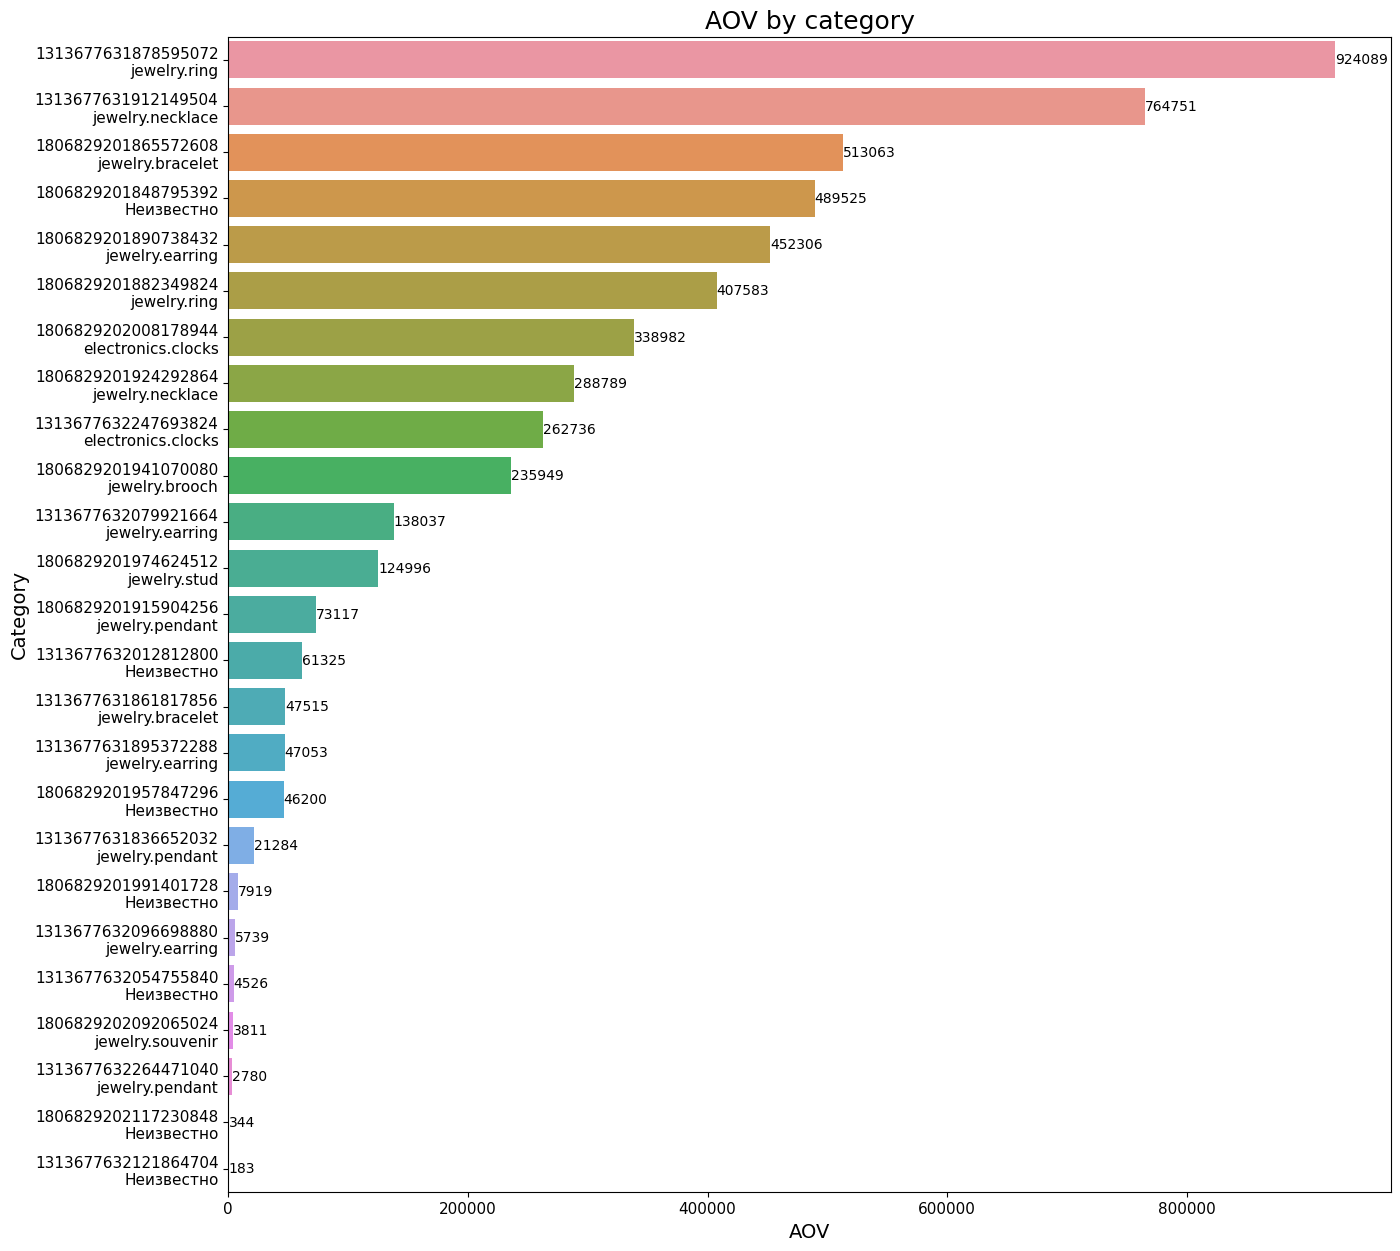

CPU times: user 285 ms, sys: 180 ms, total: 465 ms
Wall time: 249 ms


In [157]:
%%time
df = input_df.copy(deep=True)
df

# gmv
df['gmv'] = df['price'] * df['price']

# Средний чек по категориям
df = df.groupby(by=['category_id', 'category'], as_index=False).agg(gmv=('gmv', 'sum'),
                                                                    orders_cnt=('order_id', lambda s2: s2.nunique()))
df['aov'] = (df['gmv'] / df['orders_cnt']).astype('int')
df

df['cat1'] = df['category'].apply(lambda x: x.split('.')[0])
df['category'] = df[['category_id', 'category']].apply(lambda x: f'{x[0]}\n{x[1]}', axis=1)

# 
aov_df = df.copy(deep=True)
aov_df = aov_df.sort_values(by=['aov'], ascending=False).reset_index(drop=True)
aov_df

print(aov_df.groupby(by=['cat1'], as_index=False)['aov'].mean())

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 15))

b = sns.barplot(data=aov_df, x='aov', y='category')
# b = sns.catplot(data=penguins, kind="bar", x="aov", y="category", hue="sex

b.axes.set_title("AOV by category", fontsize=18)
b.set_xlabel("AOV", fontsize=14)
b.set_ylabel("Category", fontsize=14)
b.tick_params(labelsize=11)
b.bar_label(b.containers[0])

plt.show()

# `SQL`

In [160]:
input_df

,user_id,user_gender,order_id,order_month,order_ts,category_id,category,brand_id,product_id,c1,c2,c3,price,sku_qty
0,1515915625207851264,Неизвестно,1924719191579951782,2018-12-01,2018-12-01 11:40:29,1806829201890738432,jewelry.earring,0,1842195256808833386,red,gold,diamond,561.51,1
1,1515915625071970048,Неизвестно,1924899396621697920,2018-12-01,2018-12-01 17:38:31,1806829201848795392,Неизвестно,-1,1806829193678291446,yellow,gold,?,212.14,1
2,1515915625048493568,Женский,1925511016616034733,2018-12-01,2018-12-02 13:53:42,1806829201915904256,jewelry.pendant,1,1842214461889315556,white,gold,sapphire,54.66,1
3,1515915625207630848,Женский,1925626951238681511,2018-12-01,2018-12-02 17:44:02,1806829201915904256,jewelry.pendant,0,1835566849434059453,red,gold,diamond,88.90,1
4,1515915625175329280,Неизвестно,1925740842841014667,2018-12-01,2018-12-02 21:30:19,1806829201924292864,jewelry.necklace,0,1873936840742928865,red,gold,amethyst,417.67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90554,1515915625720362496,Неизвестно,2719014477910507865,2021-12-01,2021-12-01 09:43:25,1806829201848795392,Неизвестно,0,1956663836392031039,red,gold,?,134.29,1
90555,1515915625720367360,Неизвестно,2719018098886705639,2021-12-01,2021-12-01 09:50:37,1806829201848795392,Неизвестно,0,1956663830729720074,red,gold,?,229.99,1
90556,1515915625720352000,Женский,2719018846999544322,2021-12-01,2021-12-01 09:52:06,1806829201890738432,jewelry.earring,1,1956663848219968336,white,gold,diamond,630.00,1
90557,1515915625720369664,Неизвестно,2719020596963836492,2021-12-01,2021-12-01 09:55:35,1806829201890738432,jewelry.earring,0,1835566854106513435,white,gold,fianit,83.42,1


## 2. Построить когортный retention rate (когорта - yyyymm)

In [ ]:
# df_piv = pd.pivot_table(df_grp, index=['user_first_order_month', 'cohort_users_cnt'],
#                         columns=['month_rn'], values=['RetentionRate'])

q = '''
with first_month as
    (
    --Месяц первого заказа пользователя + порядок месяца относительно 1го заказа
    select
        *,
        min(order_month) over(partition by user_id order by order_ts) as user_first_order_month,
        (min(order_month) over(partition by user_id order by order_ts) - order_month) as month_rn
    from table t
    ),
    
    grpd as
    (
    --+столбец кол-ва клиентов в когорте
    select
        a.user_first_order_month,
        first(a.users_cnt) over(partition by a.user_first_order_month order by a.month_rn) as cohort_users_cnt, 
        a.month_rn,
        a.users_cnt
    from (
        --Кол-во пользователей по когортам
        select
            user_first_order_month,
            month_rn,
            count(distinct user_id) as users_cnt
        from first_month t
        group by 1, 2
        ) a
    )
select
    *
from grpd;
'''

## 3. Посчитать когортный repurchase в 1 - 10 покупку

In [ ]:
q = '''
with first_month as
    (
    --Месяц первого заказа пользователя + порядок месяца относительно 1го заказа
    select
        *,
        min(order_month) over(partition by user_id order by order_ts) as user_first_order_month,
        row_number() over(partition by user_id order by order_ts) as order_rn
    from table t
    limit 11 over (partition by user_id order by order_ts)
    ),
    
    grpd as
    (
    --+столбец кол-ва клиентов в когорте
    select
        a.user_first_order_month,
        first(a.users_cnt) over(partition by a.user_first_order_month order by a.order_rn) as cohort_users_cnt, 
        a.order_rn,
        a.users_cnt
    from (
        --Кол-во пользователей по когортам
        select
            user_first_order_month,
            order_rn,
            count(distinct user_id) as users_cnt
        from first_month t
        group by 1, 2
        ) a
    )
select
    *
from grpd;
'''